In [ ]:
import scipy.io

In [ ]:
from scipy.io import loadmat

In [ ]:
dataset = loadmat("/content/Scenario1.mat")

In [ ]:
print(type(dataset))

<class 'dict'>


In [ ]:
print(dataset.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Cv_V1', 'Cv_V2', 'Cv_V3', 'Cv_V4', 'Cv_V5', 'Cv_V6', 'Cv_V7', 'Ecoeff', 'H0', 'T0', 'Tc1i', 'Tc2i', 'coeff', 'deltat', 'dx', 'nstep', 't', 't_Elapsed', 't_Start', 'tspan', 'tt', 'u', 'u0', 'u0_d', 'u_d', 'ui', 'ui_d', 'x0d', 'x_d', 'xo', 'y', 'ysp_Vol'])


In [ ]:
dataset1 = loadmat("/content/Scenario2.mat")

In [ ]:
print(dataset1.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Cv_V1', 'Cv_V2', 'Cv_V3', 'Cv_V4', 'Cv_V5', 'Cv_V6', 'Cv_V7', 'Ecoeff', 'H0', 'T0', 'Tc1i', 'Tc2i', 'coeff', 'deltat', 'dx', 'nstep', 't', 't_Elapsed', 't_Start', 'tspan', 'tt', 'u', 'u0', 'u0_d', 'u_d', 'ui', 'ui_d', 'x0d', 'x_d', 'xo', 'y', 'ysp_Vol'])


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [ ]:

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:

def generate_2var_data(N=100):
    np.random.seed(42)
    x1 = np.random.uniform(-1, 1, N)
    x2 = np.tanh(3*x1) + np.random.normal(0, 0.05, N)
    return np.column_stack([x1, x2])

In [ ]:

def generate_5var_data(N=300):
    np.random.seed(42)
    x1 = np.random.uniform(-2, 2, N)
    x2 = np.random.uniform(-2, 2, N)
    x3 = np.random.uniform(-2, 2, N)
    x4 = np.sin(3*x1) + np.random.normal(0, 0.5, N)
    x5 = x2 - np.tan(0.5*x3) + np.random.normal(0, 0.5, N)
    return np.column_stack([x1, x2, x3, x4, x5])

In [ ]:
class Autoencoder_OrderedVariance(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 5),
            nn.ReLU(),
            nn.Linear(5, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 5),
            nn.ReLU(),
            nn.Linear(5, input_dim)
        )

    def forward(self, x):
        y = self.encoder(x)
        x_recon = self.decoder(y)
        return x_recon, y

In [ ]:
def ae_loss(model, x, x_recon, y, Q, alpha=1.5, beta=7, gamma=0.75):
    # Reconstruction loss
    recon_loss = alpha * torch.mean((x - x_recon)**2)

    # Variance regularization (Ordering loss)
    y_centered = y - torch.mean(y, dim=0)
    var_loss = beta * torch.trace(y_centered.T @ y_centered @ Q)

    # Weight regularization (L2)
    l2_reg = gamma * sum(p.pow(2.0).sum() for p in model.parameters())

    return recon_loss + var_loss + l2_reg, recon_loss, var_loss, l2_reg

In [ ]:
def train_aeo(data,q_values,input_dim):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {
        'latent_vars': [],
        'recon_loss': [],
        'var_loss': [],
        'weight_loss': [],
        'epoch_losses': {q: [] for q in q_values}
    }

    X = torch.FloatTensor(data).to(device)

    for q in q_values:
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        random.seed(SEED)

        model = Autoencoder_OrderedVariance(input_dim, input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        if input_dim == 2:
            Q = torch.diag(torch.FloatTensor([1, q**2])).to(device)
        else:
            Q = torch.diag(torch.FloatTensor([0.1, 0.1*q, 0.5*q, 4*q, 5*q])).to(device)

        print(f"\nTraining for q={q}:")
        for epoch in range(800):
            x_recon, y = model(X)
            total_loss, recon_loss, var_loss, weight_loss = ae_loss(model, X, x_recon, y, Q)

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            results['epoch_losses'][q].append(total_loss.item())

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Total Loss = {total_loss.item():.4f}, "
                      f"Recon = {recon_loss.item():.4f}, Var = {var_loss.item():.4f}, "
                      f"Weight = {weight_loss.item():.4f}")

        with torch.no_grad():
            y = model.encoder(X)
            latent_vars = torch.var(y, dim=0).cpu().numpy()

        results['latent_vars'].append(latent_vars)
        results['recon_loss'].append(recon_loss.item())
        results['var_loss'].append(var_loss.item())
        results['weight_loss'].append(weight_loss.item())

    return results


Training for q=1:
Epoch 0: Total Loss = 21.8190, Recon = 0.8397, Var = 15.8751, Weight = 5.1042
Epoch 100: Total Loss = 6.4407, Recon = 0.7740, Var = 1.9061, Weight = 3.7605
Epoch 200: Total Loss = 4.5210, Recon = 0.7749, Var = 0.8872, Weight = 2.8588
Epoch 300: Total Loss = 3.4595, Recon = 0.7760, Var = 0.4636, Weight = 2.2200
Epoch 400: Total Loss = 2.7912, Recon = 0.7765, Var = 0.2456, Weight = 1.7691
Epoch 500: Total Loss = 2.3555, Recon = 0.7766, Var = 0.1320, Weight = 1.4469
Epoch 600: Total Loss = 2.0642, Recon = 0.7767, Var = 0.0769, Weight = 1.2105
Epoch 700: Total Loss = 1.8554, Recon = 0.7767, Var = 0.0479, Weight = 1.0307

Training for q=2:
Epoch 0: Total Loss = 75.9650, Recon = 0.8047, Var = 69.9130, Weight = 5.2473
Epoch 100: Total Loss = 7.8284, Recon = 0.7784, Var = 3.2958, Weight = 3.7543
Epoch 200: Total Loss = 4.9465, Recon = 0.7761, Var = 1.3329, Weight = 2.8376
Epoch 300: Total Loss = 3.6783, Recon = 0.7761, Var = 0.6598, Weight = 2.2424
Epoch 400: Total Loss = 2.

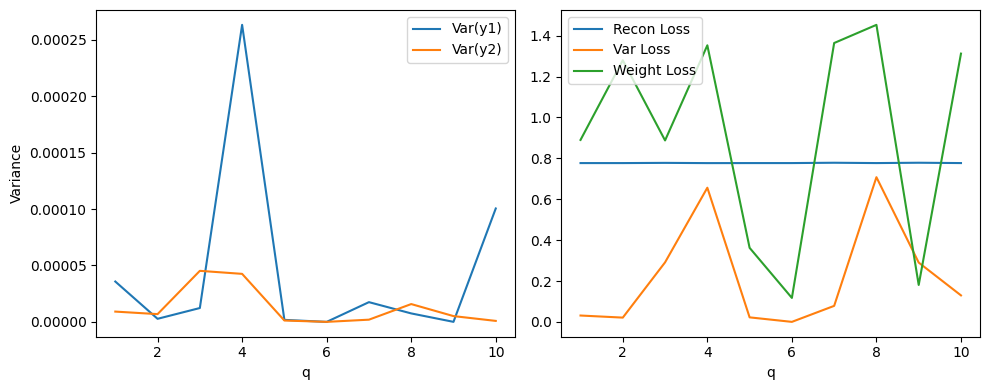

In [ ]:

data_2var = generate_2var_data()
q_values = np.arange(1, 11)
results_2var = train_aeo(data_2var,q_values,input_dim=2)


plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(q_values, [v[0] for v in results_2var['latent_vars']], label='Var(y1)')
plt.plot(q_values, [v[1] for v in results_2var['latent_vars']], label='Var(y2)')
plt.xlabel('q')
plt.ylabel('Variance')
plt.legend()

plt.subplot(122)
plt.plot(q_values, results_2var['recon_loss'], label='Recon Loss')
plt.plot(q_values, results_2var['var_loss'], label='Var Loss')
plt.plot(q_values, results_2var['weight_loss'], label='Weight Loss')
plt.xlabel('q')
plt.legend()
plt.tight_layout()




Training for q=1:
Epoch 0: Total Loss = 2784.7192, Recon = 2.4140, Var = 2775.8923, Weight = 6.4129
Epoch 100: Total Loss = 499.3988, Recon = 2.2350, Var = 493.4331, Weight = 3.7307
Epoch 200: Total Loss = 146.7819, Recon = 2.1710, Var = 142.1380, Weight = 2.4729
Epoch 300: Total Loss = 68.0084, Recon = 2.1407, Var = 64.0036, Weight = 1.8640
Epoch 400: Total Loss = 36.2295, Recon = 2.1266, Var = 32.5309, Weight = 1.5719
Epoch 500: Total Loss = 21.3085, Recon = 2.1205, Var = 17.7542, Weight = 1.4339
Epoch 600: Total Loss = 14.3095, Recon = 2.1181, Var = 10.8251, Weight = 1.3663
Epoch 700: Total Loss = 10.7999, Recon = 2.1172, Var = 7.3536, Weight = 1.3291

Training for q=2:
Epoch 0: Total Loss = 1671.8326, Recon = 2.3188, Var = 1663.5504, Weight = 5.9634
Epoch 100: Total Loss = 294.2192, Recon = 2.1950, Var = 288.4384, Weight = 3.5857
Epoch 200: Total Loss = 101.3263, Recon = 2.1497, Var = 96.7772, Weight = 2.3994
Epoch 300: Total Loss = 48.0552, Recon = 2.1308, Var = 44.1178, Weight =

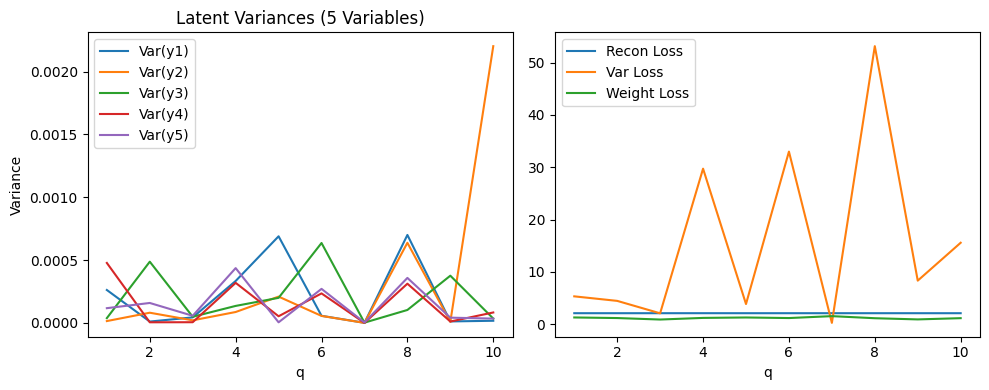

In [ ]:
data_5var = generate_5var_data()

q_values = np.arange(1, 11)
results_5var = train_aeo(data_5var,q_values,input_dim=5)

plt.figure(figsize=(10,4))
plt.subplot(121)
for i in range(5):
    plt.plot(q_values, [v[i] for v in results_5var['latent_vars']], label=f'Var(y{i+1})')

plt.xlabel('q')
plt.ylabel('Variance')
plt.legend()
plt.title('Latent Variances (5 Variables)')
# Plot Figure 3(b): Loss Components
plt.subplot(122)
plt.plot(q_values, results_5var['recon_loss'], label='Recon Loss')
plt.plot(q_values, results_5var['var_loss'], label='Var Loss')
plt.plot(q_values, results_5var['weight_loss'], label='Weight Loss')
plt.xlabel('q')
plt.legend()
plt.tight_layout()